In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
FP = 'log/regression_QM7/2022-11-23_14-19/epoch_results.txt'

In [3]:
df = pd.read_table(FP)

In [4]:
df.head()

,epoch,n_test,n_train,n_val,test_MSE,train_MSE,val_MSE
0,0,100,450,50,2.355794e+06,2419583.750,2.357527e+06
1,1,100,450,50,2.185854e+06,2306623.000,2.189666e+06
2,2,100,450,50,1.666826e+06,1977363.000,1.676798e+06
3,3,100,450,50,7.195706e+05,1255814.375,7.255789e+05
4,4,100,450,50,4.272843e+04,331685.000,5.143910e+04


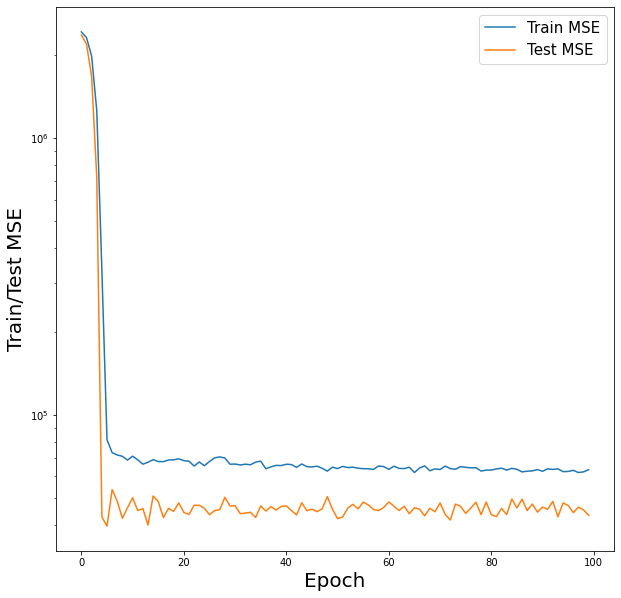

In [8]:
fig, ax = plt.subplots()

fig.patch.set_facecolor('white')
fig.set_size_inches(10, 10)

ax.plot(df['epoch'], df['train_MSE'], '-', label='Train MSE')
ax.plot(df['epoch'], df['test_MSE'], '-', label='Test MSE')

ax.set_yscale('log')
ax.set_xlabel('Epoch', size=20)
ax.set_ylabel('Train/Test MSE', size=20)


ax.legend(prop={'size': 15})
plt.show()